# Generating returns

Let $P_{i,t}$ denote the price of asset $i=1,\ldots,N$, which pays no divides, at times $t=0,\ldots,T$. 

The _simple net return_, $R_{i,t}$, between the times $t-1$ and $t$, for asset $i$, is defined as
$$
R_{i,t} = \frac{P_{i,t}-P_{i,t-1}}{P_{i,t-1}} =  \frac{P_{i,t}}{P_{i,t-1}} - 1, \quad \forall i=1,\ldots,N \text{ and } \forall t = 1,\ldots,T.
$$

The _simple gross return_ on asset $i$ at time $t$ is defined as 
$$
1+R_{i,t} = \frac{P_{i,t}}{P_{i,t-1}}, \quad \forall i=1,\ldots,N \text{ and } \forall t = 1,\ldots,T.
$$

The _continuousy compunded return_ or _log return_, $r_{i,t}$, on asset $i$ at time $t$ is defined as the natural logarithm of the simple gross return, i.e.
$$
r_{i,t} = \ln(1+R_{i,t}) = \ln \left(\frac{P_{i,t}}{P_{i,t-1}}\right), \quad \forall i=1,\ldots,N \text{ and } \forall t = 1,\ldots,T.
$$

Let 
$$
P_{t} = 
\begin{bmatrix}
P_{1,t} \\
\vdots \\
P_{N,t} \\
\end{bmatrix}, \quad \forall t = 0,\ldots,T, \\
R_{t}=
\begin{bmatrix}
R_{1,t} \\
\vdots \\
R_{N,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T, \\
r_{t}=
\begin{bmatrix}
r_{1,t} \\
\vdots \\
r_{N,t} \\
\end{bmatrix}, \quad \forall t = 1,\ldots,T.
$$
---
The following code gererates simulated log returns $r_{t}$ such that
$$
r_{t} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(\tilde{\mu},\tilde{\Sigma}\right),\quad \forall t=1,\ldots,T
$$
for some randomly chosen $\tilde{\mu}\in\mathbb{R}^{N}$ and $\tilde{\Sigma}\in\mathbb{S}_{++}^{N}$.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(1)

T = 10000 # number of trading periods.
N = 30 # number of stocks

mu_tilde = 0.0001*(rng.random(N)-0.5)
temp = rng.normal(0,0.01,(N,N))
Sigma_tilde = 0.01 * (temp.T @ temp + 0.0001 * np.eye(N))
r = rng.multivariate_normal(mu_tilde,Sigma_tilde,T)

Typically, you do not have access to $\tilde\mu$ and $\tilde\Sigma$, i.e. these model parameters need to be estimated directly or indirectly. More fundamentally, assuming iid normality on the log returns is computationally tractable, but not necessarily true empirically. 

--- 

The following code calculates the simple net returns $R_{t}$

In [2]:
R = np.exp(r) - 1

The expected simple net return $\mu=\operatorname{\mathbb{E}}[ R_{t}]\in\mathbb{R}^{N}$ and the covariance matrix of the simple net return $\Sigma=\operatorname{Var}[ R_{t}]\in\mathbb{S}_{++}^{N}$ are given by 
$$
\mu_i=\exp\left(\tilde\mu_i+\frac{1}{2}\tilde\Sigma_{ii}\right)-1,\quad \forall i = 1,\ldots,N \text{ and }\forall t=1,\ldots,T
$$
and
$$
\Sigma_{ij}=\exp\left(\tilde\mu_i+\tilde\mu_j + \frac{1}{2}\left(\tilde\Sigma_{ii}+\tilde\Sigma_{jj}\right) \right)\left( \exp\left(\tilde\Sigma_{ij}\right) - 1\right),\quad \forall i,j = 1,\ldots,N \text{ and }\forall t=1,\ldots,T
$$
respectively (show this if you want to). These quantities are calculated below.

In [3]:
mu = np.exp(mu_tilde + 0.5 * np.diag(Sigma_tilde)) - 1
Sigma = np.exp(mu_tilde.reshape(N, 1) @ np.ones((1,N))
               + np.ones((N,1)) @ mu_tilde.reshape(1, N)
               + 0.5 * np.diag(Sigma_tilde).reshape(N, 1) @ np.ones((1,N))
               + 0.5 * np.ones((N,1)) @ np.diag(Sigma_tilde).reshape(1, N)
              ) * np.exp(Sigma_tilde-1)

If we wish, we can generate a price time series $P_{t}$ as below.

In [4]:
P_0 = rng.integers(low=100, high=1000, size=N)
P = np.ndarray((T+1,N))
P[0,:] = P_0
for t in range(T):
    P[t+1,:] = (R[t,:]+1)*P[t,:]

Below is a simple figure showing the prices $P_{t}$.

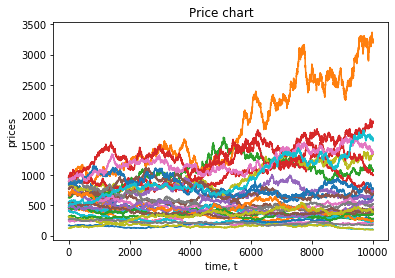

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, axes = plt.subplots()
axes.plot(P)
axes.set_xlabel('time, t')
axes.set_ylabel('prices')
axes.set_title('Price chart');

However, we are not primarily intrested in the prices $P_{t}$, but rather the returns $R_{t}$.

# Portfolio selection

Assume that times $t$ are trading days. Given the simple net returns $R_{t}$, the expected simple net returns $\mu=\operatorname{\mathbb{E}}[ R_{t}]$ and the covariance matrix of the simple net returns $\Sigma=\operatorname{Var}[ R_{t}]$ above, try to implement a simplied version of single-period method in "Multi-Period Trading via Convex Optimization" Boyd et al. I.e. use (4.5), ignore the trade and hold terms, use absolute risk as your risk measure and assume no risk-free asses/cash balance.

Start of with initial wealth $1000000$ SEK and uniform allocation across the $N$ asssets, at time $t=0$.

In [20]:
import cvxpy as cvx

def SPO_mark(exp_netRet, cov, risk):
    weights = cvx.Variable(len(exp_netRet))
    
    expected_netReturn = weights.T @ exp_netRet
    expected_volatility = cvx.quad_form(weights, cov) # weights * cov * weights.T
    
    # utility = expected_netReturn
    utility = expected_netReturn - expected_volatility
    objective = cvx.Maximize(utility)
    #ret_data = np.zeros(len(exp_netRet))
    
    constraints = [
        cvx.sum(weights) == 1,
        weights >= 0,
    ] 
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    
    return np.array(weights.value), expected_netReturn, expected_volatility.value

In [21]:
# mu = expected return, cov = Sigma
weights, rets, var = SPO_mark(mu, Sigma, np.std(R)) # risk as st deviation

print('Weights',weights); print('Expected return',rets.value*1E6); print('Expected Variance',var*1E6)

Weights [0.03323437 0.04152084 0.02719469 0.04217877 0.03102543 0.03235694
 0.03853302 0.03031736 0.03430717 0.02416174 0.03808437 0.03452268
 0.02990731 0.0379419  0.03022257 0.03217007 0.02540578 0.02973773
 0.02744498 0.02801281 0.03884355 0.029311   0.0339719  0.04183161
 0.04130573 0.03684754 0.03336231 0.02734095 0.02726984 0.04163503]
Expected return 21.164509120000126
Expected Variance 367895.5028223915


# Performance metrics
As a bare minimum, calculate the (annualized) Sharpe Ratio and avarage turnover. Note that there are approximatly $252$ trading days in a calender year.

In [27]:
# Sharpe Ratio tells the return of an investment compared to its risk
sharpeRatio = rets.value/var
print('Sharpe Ratio:',sharpeRatio)

# Average turnover = sum(abs (u_t)/2)
# sometimes descr. as percentage z_t = u_t / v_t , v_t 'total portfolio value at time t', u_t 'kassaflöde vid perioden t'
print(rets)


Sharpe Ratio: 5.752858884556056e-05
var289 @ [ 2.35297082e-05  5.81874156e-05 -2.03129260e-05  6.17051841e-05
  1.43678817e-06  7.68986129e-06  5.03156436e-05  4.10337628e-06
  1.94982195e-05 -3.11984114e-05  3.58197409e-05  2.42207852e-05
 -7.60996103e-06  4.44227929e-05 -4.01412478e-07  7.45203524e-06
 -2.64108976e-05  2.18779811e-06 -1.06273812e-05 -7.25435396e-06
  4.15326499e-05  2.20906805e-06  1.37392479e-05  6.32281575e-05
  6.26094733e-05  3.37159946e-05  1.60090575e-05 -1.35424852e-05
 -1.26474557e-05  5.81816104e-05]


TypeError: object of type 'MulExpression' has no len()

# Remark
Try to get this rumming as soon as possible. This can be done in parallel with the data collection.

Later on, you will need to estimate $\mu=\operatorname{\mathbb{E}}[ R_{t}]$ or even directly predict/forcast $R_{t}$. The same holds for $\Sigma=\operatorname{Var}[ R_{t}]$.